# FastSMC example notebook

This notebook demonstrates how to use the FastSMC python bindings, with optional configuration of parameters.

Please make sure you have installed the python bindings by following the instructions in `../README.md` before attempting to run this notebook.

The example dataset was simulated using the setup described in the paper, corresponding to SNP data for 150 diploid individuals and a chromosomal region of 30 Mb, with recombination rate from chromosome 2 and under a European demographic model (see https://www.biorxiv.org/content/10.1101/2020.04.20.029819v1 for more details).

1. import the necessary modules, including from `asmc` which is installed with the Python bindings

In [1]:
%config InlineBackend.figure_formats = ['svg']

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from asmc import *

2. Find the example data provided with ASMC that we will use for this notebook

In [2]:
# Get the base ASMC directory
base_dir = os.path.abspath('..')

file_dir = os.path.join(base_dir, 'FILES', 'FASTSMC_EXAMPLE')
name_prefix = 'out.25.n300.chr2.len30.dens1.disc10-20-2000.demoCEU.mapnorm.array'

input_path = os.path.join(file_dir, name_prefix)
decoding_quantities_file = os.path.join(file_dir, f'{name_prefix}.decodingQuantities.gz')

# Ouput files will be generated alongside this notebook in a directory named 'tmp_output'
output_dir = os.path.join(base_dir, 'notebooks', 'tmp_output')

3. Set the required parameters by creating a DecodingParams object. When creating parameters in this manner, you should run `validateParamsFastSMC()` to ensure you have not selected incompatible options.

In [3]:
params = DecodingParams()
params.decodingQuantFile = decoding_quantities_file
params.inFileRoot = os.path.join(file_dir, name_prefix)
params.outFileRoot = os.path.join(output_dir, 'fastsmc_output')
params.decodingModeString = 'array'
params.decodingMode = DecodingMode.arrayFolded
params.foldData = True
params.usingCSFS = True
params.batchSize = 32
params.recallThreshold = 3
params.min_m = 1.5
params.GERMLINE = True
params.FastSMC = True
params.BIN_OUT = False
params.time = 50
params.noConditionalAgeEstimates = True
params.doPerPairMAP = True
params.doPerPairPosteriorMean = True

assert params.validateParamsFastSMC()

4. Create the Python FastSMC object and run it. This should only take a few seconds.

In [4]:
fast_smc = FastSMC(params)
fast_smc.run()

5. Read data, add column names, filter to remove IBD segments with extremely low IBD score, and calculate a summary statistic of IBD segment length

In [1]:
data = pd.read_csv(f'{output_dir}.1.1.FastSMC.ibd.gz', sep='\t', header=None)


data.columns = ['ind1_famid', 'ind1_id', 'ind1_hap', 'ind2_famid', 'ind2_id', 'ind2_hap',
                'chromosome', 'ibd_start', 'ibd_end', 'ibd_score', 'post_est', 'map_est']

filtered = data[data['ibd_score'] > 0.001]


# Calculate IBD segment length in number of base pairs
filtered.insert(9, 'ibd_length', data['ibd_end'] - data['ibd_start'] + 1)
filtered

NameError: name 'pd' is not defined

6. Visualise data: here we simply bin the posterior age estimates of the IBD segments, and the IBD segment length

<AxesSubplot:xlabel='MAP age estimate (in generations)'>

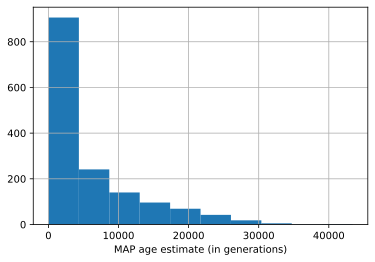

In [6]:
plt.xlabel("MAP age estimate (in generations)")
data['map_est'].hist()


<AxesSubplot:xlabel='IBD segments length (in kbp)'>

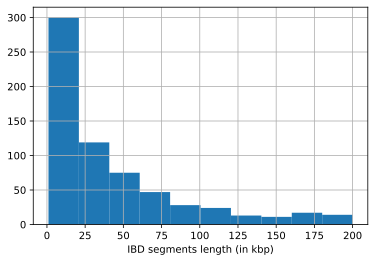

In [7]:
plt.xlabel("IBD segments length (in kbp)")
(data['ibd_length'] / 1000).hist(range=[1, 200])